# INF-0616 - Aula 4: classificação de reviews de filmes do IMDB
O exemplo abaixo foi adaptado de fchollet/deep-learning-with-python-notebooks/.../3.5-classifying-movie-reviews.

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Jesus Paucar -- j236865@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina:
[moodle.lab.ic.unicamp.br/680](https://moodle.ic.unicamp.br/moodle/course/view.php?id=680)

Instituto de Computação - Unicamp 2025

Instituto de Computação - Unicamp 2024



In [ ]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras import callbacks
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

np.random.seed(42)
sns.set()

def readIMDBData():
    #Just a gimmick to be able to read imdb data with this version of numpy
    ### ============
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
    np.load = np_load_old

    return (x_train, y_train), (x_test, y_test)

## Determinando sentimento (positivo ou negativo) em *reviews* no **IMDB**
### Lendo o conjunto de dados

**IMDB** é um conjunto contendo reviews textuais previamente processadas e rótulos de sentimento (positivo ou negativo) associados à cada review.

O conjunto é internalizado no keras e pode ser lido da seguinte forma:

In [ ]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000)

labels = 'negative positive'.split()

print(x_train.shape, x_test.shape)

(25000,) (25000,)


#### 2 primeiras amostras no conjunto de treinamento

Cada palavra foi codificada por um inteiro identificador. Um documento é então representado por um vetor de inteiros.

In [ ]:
print(*x_train[:2], sep='\n\n')

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 

Podemos decodificar as mensagens em palavras olhando para o mapa inverso:

In [ ]:
_words = imdb.get_word_index()
_rwords = {wo: ix for ix, wo in _words.items()}

def decode_review(review):
    # Indexamos a partir do 3 pois 0, 1 and 2 sao reservados para "padding",
    # "start of sequence", and "unknown".
    return ' '.join([_rwords.get(i - 3, '?') for i in review])

print(*(decode_review(r) for r in x_train[:2]), sep='\n\n')

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

E podemos ver também o rótulo destas duas amostas:

In [ ]:
print([labels[y] for y in y_train[:2]])

['positive', 'negative']


### Preprocessamento

Muito pre-processamento já foi feito sobre o conjunto, como eliminação de artigos, preposições e `stop-words`. Precisamos agora vetorizar os vetores de reviews para eliminar a enumeração natural dos inteiros, de forma similar como ocorre com o vetor de classes, para casos multi-classe, onde aplicamos o *one-hot encoding*:

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

y_train = y_train.astype(float)
y_test = y_test.astype(float)

### Visualizando frequências das classes no conjunto

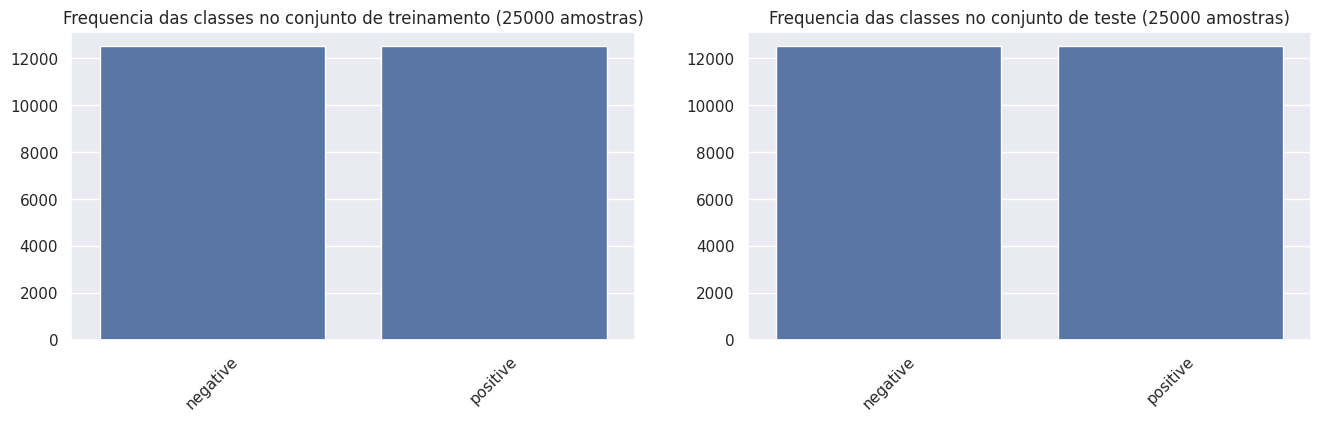

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % x_train.shape[0])
_, counts = np.unique(y_train, return_counts=True)
sns.barplot(x=labels, y=counts)
plt.xticks(rotation=45)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % x_test.shape[0])
_, counts = np.unique(y_test, return_counts=True)
sns.barplot(x=labels, y=counts)
plt.xticks(rotation=45);

## PyTorch Framework
Separamos parte do conjunto de treinamento para usá-lo como um conjunto de validação porque o PyTorch não tem um método interno que executa essa separabilidade.

In [ ]:
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size = 0.3, stratify = y_train, random_state = 42)

In [ ]:
print(f'Shape of Train inputs: {x_train.shape}')
print(f'Shape of Train labels: {y_train.shape}')
print(f'Shape of Val inputs: {x_val.shape}')
print(f'Shape of Val labels: {y_val.shape}')
print(f'Shape of Test inputs: {x_test.shape}')
print(f'Shape of Test labels: {y_test.shape}')

Shape of Train inputs: (17500, 10000)
Shape of Train labels: (17500,)
Shape of Val inputs: (7500, 10000)
Shape of Val labels: (7500,)
Shape of Test inputs: (25000, 10000)
Shape of Test labels: (25000,)


Encapsulamos nossos dados por meio da classe Dataset para que possamos criar continuamente nossos blocos de dados (DataLoader) que são usados ​​durante o treinamento.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score

class IMDBDataset(Dataset):

  def __init__(self, x_data, y_data):

    self.x = torch.tensor(x_data, dtype = torch.float32)
    self.y = torch.tensor(y_data, dtype = torch.float32)

  def __len__(self):

    return len(self.y)

  def __getitem__(self, idx):

    return self.x[idx], self.y[idx]

In [ ]:
batch_size = 64 #512

train_dataset = IMDBDataset(x_train, y_train)
val_dataset = IMDBDataset(x_val, y_val)
test_dataset = IMDBDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
print(f'Batch X: {x_batch.shape}')
print(f'Batch Y: {y_batch.shape}')

Batch X: torch.Size([64, 10000])
Batch Y: torch.Size([64])


Definição da Rede Neural

In [ ]:
class SentimentoNN(nn.Module):

  def __init__(self, input_dim):

    super(SentimentoNN, self).__init__()

    self.fc1 = nn.Linear(input_dim, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 1)
    self.activation1 = nn.ReLU()
    #self.activation2 = nn.Sigmoid()

  def forward(self, x):

    x = self.activation1(self.fc1(x))
    x = self.activation1(self.fc2(x))
    #x = self.activation2(self.fc3(x))
    x = self.fc3(x)

    return x

Criamos a função de Treinamento

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs = 10, device = 'cpu', save_path = 'best_model.pth'):

  model.to(device)

  history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

  best_val_acc = 0.0

  for epoch in range(epochs):

    model.train()

    train_loss, train_preds, train_labels = 0.0, [], []

    loop = tqdm(train_loader, desc = f'Epoch [{epoch + 1}/{epochs}]', leave = False)

    for signal, label in loop:

      signal, label = signal.to(device), label.to(device).float()

      optimizer.zero_grad()
      outputs = model(signal).squeeze()
      loss = criterion(outputs, label)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * signal.size(0)
      preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
      train_preds.extend(preds)
      train_labels.extend(label.cpu().numpy())

      loop.set_postfix(loss = loss.item())

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():

      for signal, label in val_loader:

        signal, label = signal.to(device), label.to(device).float()
        outputs = model(signal).squeeze()
        loss = criterion(outputs, label)

        val_loss += loss.item() * signal.size(0)
        preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
        val_preds.extend(preds)
        val_labels.extend(label.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch [{epoch + 1}/{epochs}] '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} '
          f'| Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Save model
    if val_acc > best_val_acc:

      best_val_acc = val_acc
      torch.save(model.state_dict(), save_path)
      print('-' * 80)
      print(f'Melhor modelo atualizado (Val Acc: {best_val_acc:.4f}) salvo em {save_path}')
      print('-' * 80)

  return history

In [ ]:
def evaluate_model(model, test_loader, device = 'cpu'):

  model.eval()

  preds, labels = [], []

  with torch.no_grad():

    for signal, label in test_loader:

      signal, label = signal.to(device), label.to(device).float()
      outputs = model(signal).squeeze()
      preds.extend((outputs.cpu().numpy() > 0.5).astype(int))
      labels.extend(label.cpu().numpy())

  acc = accuracy_score(labels, preds)
  print(f'Test Accuracy: {acc:.4f}')
  print('-' * 60)
  print(classification_report(labels, preds, target_names = ['negative', 'positive']))

  return labels, preds, acc

In [ ]:
def plot_history(history):

  plt.figure(figsize = (16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(history['train_loss'], label = 'Train Loss')
  plt.plot(history['val_loss'], label = 'Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss x Epoch')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history['train_acc'], label = 'Train Accuracy')
  plt.plot(history['val_acc'], label = 'Val Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy x Epoch')
  plt.legend()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 30
model = SentimentoNN(input_dim = 10000).to(device)
criterion = nn.BCEWithLogitsLoss() # pode utilizar nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

In [ ]:
history = train_model(model = model,
                      train_loader = train_loader,
                      val_loader = val_loader,
                      criterion = criterion,
                      optimizer = optimizer,
                      epochs = epochs,
                      device = device)

--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.5000) guardado en best_model.pth
--------------------------------------------------
Epoch [1/30] Train Loss: 0.6915, Train Accuracy: 0.5000 | Val Loss: 0.6896, Val Accuracy: 0.5000


Epoch [2/30] Train Loss: 0.6863, Train Accuracy: 0.5000 | Val Loss: 0.6824, Val Accuracy: 0.5000


Epoch [3/30] Train Loss: 0.6736, Train Accuracy: 0.5000 | Val Loss: 0.6631, Val Accuracy: 0.5000


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.5292) guardado en best_model.pth
--------------------------------------------------
Epoch [4/30] Train Loss: 0.6387, Train Accuracy: 0.5041 | Val Loss: 0.6097, Val Accuracy: 0.5292


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.7725) guardado en best_model.pth
--------------------------------------------------
Epoch [5/30] Train Loss: 0.5553, Train Accuracy: 0.6427 | Val Loss: 0.5076, Val Accuracy: 0.7725


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.8136) guardado en best_model.pth
--------------------------------------------------
Epoch [6/30] Train Loss: 0.4439, Train Accuracy: 0.7925 | Val Loss: 0.4124, Val Accuracy: 0.8136


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.8276) guardado en best_model.pth
--------------------------------------------------
Epoch [7/30] Train Loss: 0.3662, Train Accuracy: 0.8391 | Val Loss: 0.3634, Val Accuracy: 0.8276


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.8593) guardado en best_model.pth
--------------------------------------------------
Epoch [8/30] Train Loss: 0.3216, Train Accuracy: 0.8597 | Val Loss: 0.3520, Val Accuracy: 0.8593


Epoch [9/30] Train Loss: 0.2917, Train Accuracy: 0.8769 | Val Loss: 0.3201, Val Accuracy: 0.8556


Epoch [10/30] Train Loss: 0.2693, Train Accuracy: 0.8877 | Val Loss: 0.3099, Val Accuracy: 0.8564


Epoch [11/30] Train Loss: 0.2505, Train Accuracy: 0.8975 | Val Loss: 0.3079, Val Accuracy: 0.8547


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.8721) guardado en best_model.pth
--------------------------------------------------
Epoch [12/30] Train Loss: 0.2337, Train Accuracy: 0.9055 | Val Loss: 0.2973, Val Accuracy: 0.8721


Epoch [13/30] Train Loss: 0.2196, Train Accuracy: 0.9118 | Val Loss: 0.2967, Val Accuracy: 0.8684


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.8785) guardado en best_model.pth
--------------------------------------------------
Epoch [14/30] Train Loss: 0.2071, Train Accuracy: 0.9174 | Val Loss: 0.2956, Val Accuracy: 0.8785


Epoch [15/30] Train Loss: 0.1967, Train Accuracy: 0.9232 | Val Loss: 0.2959, Val Accuracy: 0.8725


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.8793) guardado en best_model.pth
--------------------------------------------------
Epoch [16/30] Train Loss: 0.1861, Train Accuracy: 0.9269 | Val Loss: 0.3008, Val Accuracy: 0.8793


Epoch [17/30] Train Loss: 0.1754, Train Accuracy: 0.9325 | Val Loss: 0.3057, Val Accuracy: 0.8676


--------------------------------------------------
Mejor modelo actualizado (Val Acc: 0.8816) guardado en best_model.pth
--------------------------------------------------
Epoch [18/30] Train Loss: 0.1680, Train Accuracy: 0.9353 | Val Loss: 0.3104, Val Accuracy: 0.8816


Epoch [19/30] Train Loss: 0.1589, Train Accuracy: 0.9383 | Val Loss: 0.3507, Val Accuracy: 0.8407


Epoch [20/30] Train Loss: 0.1514, Train Accuracy: 0.9423 | Val Loss: 0.3396, Val Accuracy: 0.8775


Epoch [21/30] Train Loss: 0.1433, Train Accuracy: 0.9439 | Val Loss: 0.3182, Val Accuracy: 0.8776


Epoch [22/30] Train Loss: 0.1377, Train Accuracy: 0.9471 | Val Loss: 0.3260, Val Accuracy: 0.8699


Epoch [23/30] Train Loss: 0.1297, Train Accuracy: 0.9509 | Val Loss: 0.3289, Val Accuracy: 0.8749


Epoch [24/30] Train Loss: 0.1236, Train Accuracy: 0.9542 | Val Loss: 0.3344, Val Accuracy: 0.8725


Epoch [25/30] Train Loss: 0.1171, Train Accuracy: 0.9558 | Val Loss: 0.3524, Val Accuracy: 0.8640


Epoch [26/30] Train Loss: 0.1120, Train Accuracy: 0.9587 | Val Loss: 0.3607, Val Accuracy: 0.8628


Epoch [27/30] Train Loss: 0.1068, Train Accuracy: 0.9601 | Val Loss: 0.3563, Val Accuracy: 0.8709


Epoch [28/30] Train Loss: 0.1002, Train Accuracy: 0.9650 | Val Loss: 0.3828, Val Accuracy: 0.8732


Epoch [29/30] Train Loss: 0.0943, Train Accuracy: 0.9673 | Val Loss: 0.3808, Val Accuracy: 0.8607


Epoch [30/30] Train Loss: 0.0902, Train Accuracy: 0.9694 | Val Loss: 0.3834, Val Accuracy: 0.8705


In [ ]:
history_f = pd.DataFrame(history)
history_f

,train_loss,val_loss,train_acc,val_acc
0,0.691512,0.689587,0.500000,0.500000
1,0.686295,0.682398,0.500000,0.500000
2,0.673623,0.663100,0.500000,0.500000
3,0.638736,0.609733,0.504057,0.529200
4,0.555270,0.507608,0.642686,0.772533
5,0.443864,0.412414,0.792514,0.813600
6,0.366170,0.363375,0.839143,0.827600
7,0.321553,0.352016,0.859657,0.859333
8,0.291704,0.320118,0.876857,0.855600
9,0.269298,0.309947,0.887657,0.856400


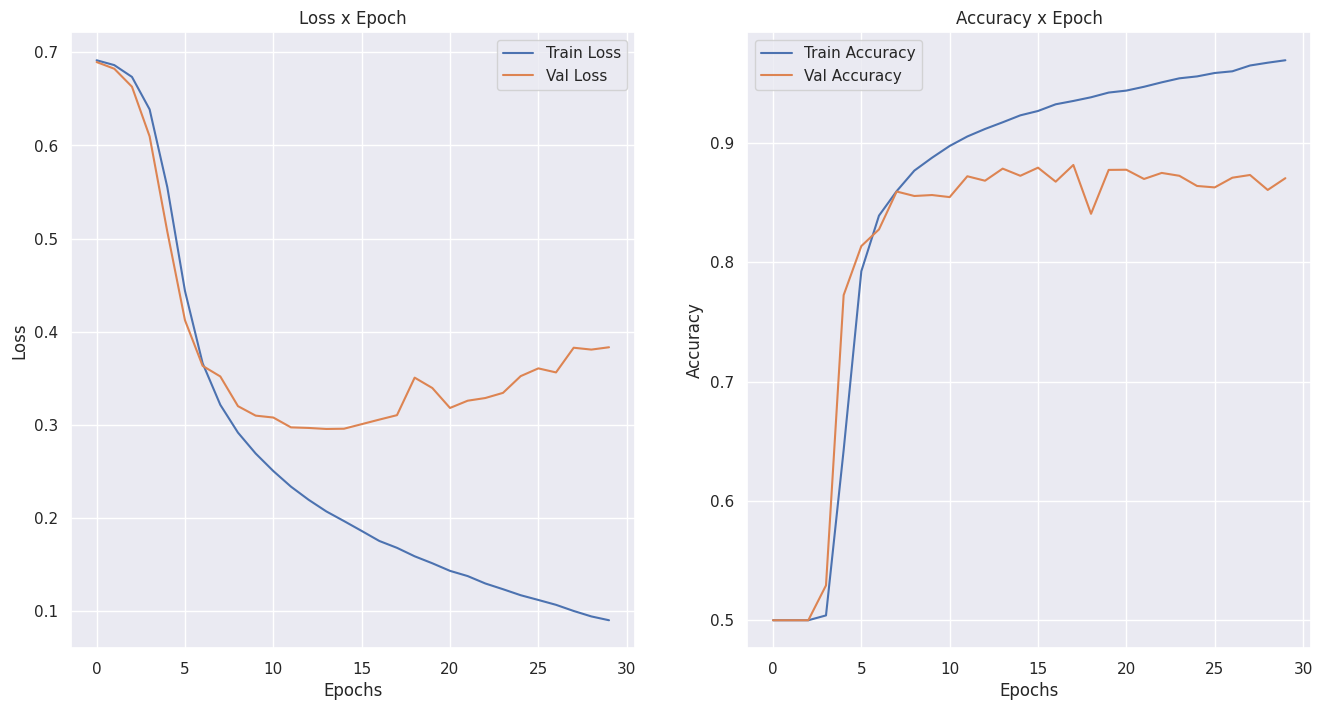

In [ ]:
plot_history(history = history)

In [ ]:
best_model = SentimentoNN(input_dim = 10000)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)
best_model.eval()

SentimentoNN(
  (fc1): Linear(in_features=10000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (activation1): ReLU()
)

In [ ]:
true_test, pred_test, acc_test = evaluate_model(model = best_model, test_loader = test_loader, device = device)

Test Accuracy: 0.8808
------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.88      0.89      0.88     12500
    positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



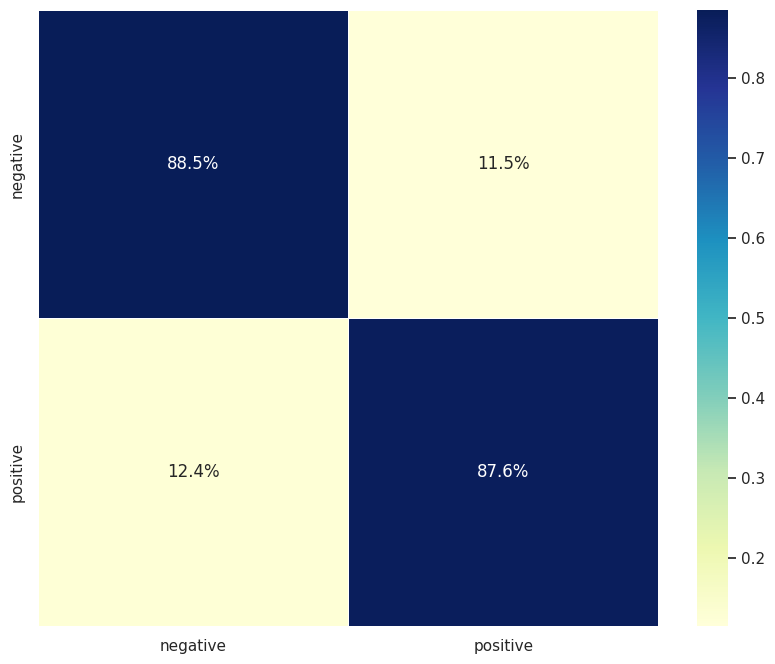

In [ ]:
c = confusion_matrix(true_test, pred_test, normalize = 'true')

plt.figure(figsize=(10, 8))
ax = sns.heatmap(c, linewidths=.5, cmap = 'YlGnBu', annot = True, fmt = '.1%', xticklabels = labels, yticklabels = labels);

### Definindo um determinador de sentimento - Tensorflow

Descreva as camadas da rede de detecção de sentimento.  
Compile o modelo utilizando o otimizador `SGD` e a função de perda `binary_crossentropy`.

In [ ]:
from keras import Sequential
from keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import SGD

model = Sequential([
    InputLayer((10000,)),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=SGD(learning_rate = 1e-2),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

Existe uma outra forma de definir modelos no Keras, utilizando a API funcional:

```
from keras import Input, Model

x = Input(shape=[1000])
y = Dense(...)(x)
y = Dense(...)(y)
model = Model(inputs=x, outputs=y)
model.compile(...)
```

Você deve conseguir ver um sumário do seu modelo, se a definição acima foi feita corretamente:

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,252,097 (20.04 MB)

 Trainable params: 5,252,097 (20.04 MB)

 Non-trainable params: 0 (0.00 B)

### Treinando o modelo

Treine o modelo definido acima sobre o conjunto.

In [ ]:
epochs = 30 # ou 20, 30, 60, 70...
batch_size = 512 # ou 128, 256, 1024, 2048...
validation_split = .3

history = model.fit(x_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_split = validation_split,
                    verbose = 1,
                    callbacks = [
                        callbacks.TerminateOnNaN(),
                        callbacks.ModelCheckpoint('networks-2-best-weights.h5',
                                                  save_best_only = True,
                                                  verbose = 1)
                        ])

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.5165 - loss: 0.6924
Epoch 1: val_loss improved from inf to 0.68932, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - binary_accuracy: 0.5170 - loss: 0.6923 - val_binary_accuracy: 0.5467 - val_loss: 0.6893
Epoch 2/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.5598 - loss: 0.6869
Epoch 2: val_loss improved from 0.68932 to 0.68492, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.5607 - loss: 0.6869 - val_binary_accuracy: 0.5760 - val_loss: 0.6849
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.5957 - loss: 0.6823
Epoch 3: val_loss improved from 0.68492 to 0.68032, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.5962 - loss: 0.6822 - val_binary_accuracy: 0.6145 - val_loss: 0.6803
Epoch 4/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.6241 - loss: 0.6780
Epoch 4: val_loss improved from 0.68032 to 0.67536, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - binary_accuracy: 0.6268 - loss: 0.6777 - val_binary_accuracy: 0.6450 - val_loss: 0.6754
Epoch 5/30
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.6702 - loss: 0.6709
Epoch 5: val_loss improved from 0.67536 to 0.66992, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.6705 - loss: 0.6709 - val_binary_accuracy: 0.6688 - val_loss: 0.6699
Epoch 6/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.6819 - loss: 0.6656
Epoch 6: val_loss improved from 0.66992 to 0.66384, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.6827 - loss: 0.6654 - val_binary_accuracy: 0.6958 - val_loss: 0.6638
Epoch 7/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.7173 - loss: 0.6587
Epoch 7: val_loss improved from 0.66384 to 0.65712, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.7174 - loss: 0.6584 - val_binary_accuracy: 0.7133 - val_loss: 0.6571
Epoch 8/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.7313 - loss: 0.6516
Epoch 8: val_loss improved from 0.65712 to 0.64962, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - binary_accuracy: 0.7317 - loss: 0.6514 - val_binary_accuracy: 0.7276 - val_loss: 0.6496
Epoch 9/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.7448 - loss: 0.6426
Epoch 9: val_loss improved from 0.64962 to 0.64127, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.7452 - loss: 0.6425 - val_binary_accuracy: 0.7438 - val_loss: 0.6413
Epoch 10/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.7598 - loss: 0.6332
Epoch 10: val_loss improved from 0.64127 to 0.63201, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - binary_accuracy: 0.7602 - loss: 0.6329 - val_binary_accuracy: 0.7552 - val_loss: 0.6320
Epoch 11/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.7776 - loss: 0.6235
Epoch 11: val_loss improved from 0.63201 to 0.62186, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.7774 - loss: 0.6233 - val_binary_accuracy: 0.7640 - val_loss: 0.6219
Epoch 12/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.7844 - loss: 0.6124
Epoch 12: val_loss improved from 0.62186 to 0.61090, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - binary_accuracy: 0.7842 - loss: 0.6120 - val_binary_accuracy: 0.7684 - val_loss: 0.6109
Epoch 13/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.7882 - loss: 0.5999
Epoch 13: val_loss improved from 0.61090 to 0.59925, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - binary_accuracy: 0.7883 - loss: 0.5998 - val_binary_accuracy: 0.7754 - val_loss: 0.5992
Epoch 14/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.7929 - loss: 0.5880
Epoch 14: val_loss improved from 0.59925 to 0.58689, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.7932 - loss: 0.5876 - val_binary_accuracy: 0.7821 - val_loss: 0.5869
Epoch 15/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.7955 - loss: 0.5762
Epoch 15: val_loss improved from 0.58689 to 0.57412, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - binary_accuracy: 0.7960 - loss: 0.5755 - val_binary_accuracy: 0.7867 - val_loss: 0.5741
Epoch 16/30
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.8021 - loss: 0.5609
Epoch 16: val_loss improved from 0.57412 to 0.56103, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - binary_accuracy: 0.8022 - loss: 0.5606 - val_binary_accuracy: 0.7907 - val_loss: 0.5610
Epoch 17/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.8069 - loss: 0.5479
Epoch 17: val_loss improved from 0.56103 to 0.54779, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - binary_accuracy: 0.8070 - loss: 0.5474 - val_binary_accuracy: 0.7956 - val_loss: 0.5478
Epoch 18/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8120 - loss: 0.5318
Epoch 18: val_loss improved from 0.54779 to 0.53452, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - binary_accuracy: 0.8120 - loss: 0.5318 - val_binary_accuracy: 0.7975 - val_loss: 0.5345
Epoch 19/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8159 - loss: 0.5179
Epoch 19: val_loss improved from 0.53452 to 0.52145, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.8157 - loss: 0.5177 - val_binary_accuracy: 0.8029 - val_loss: 0.5214
Epoch 20/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8173 - loss: 0.5053
Epoch 20: val_loss improved from 0.52145 to 0.50872, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - binary_accuracy: 0.8174 - loss: 0.5052 - val_binary_accuracy: 0.8059 - val_loss: 0.5087
Epoch 21/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8204 - loss: 0.4937
Epoch 21: val_loss improved from 0.50872 to 0.49646, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - binary_accuracy: 0.8205 - loss: 0.4935 - val_binary_accuracy: 0.8080 - val_loss: 0.4965
Epoch 22/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8284 - loss: 0.4773
Epoch 22: val_loss improved from 0.49646 to 0.48476, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - binary_accuracy: 0.8282 - loss: 0.4771 - val_binary_accuracy: 0.8126 - val_loss: 0.4848
Epoch 23/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8293 - loss: 0.4677
Epoch 23: val_loss improved from 0.48476 to 0.47346, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.8296 - loss: 0.4670 - val_binary_accuracy: 0.8171 - val_loss: 0.4735
Epoch 24/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8392 - loss: 0.4499
Epoch 24: val_loss improved from 0.47346 to 0.46315, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.8386 - loss: 0.4500 - val_binary_accuracy: 0.8200 - val_loss: 0.4632
Epoch 25/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8315 - loss: 0.4466
Epoch 25: val_loss improved from 0.46315 to 0.45311, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.8323 - loss: 0.4456 - val_binary_accuracy: 0.8251 - val_loss: 0.4531
Epoch 26/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8390 - loss: 0.4296
Epoch 26: val_loss improved from 0.45311 to 0.44387, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.8390 - loss: 0.4296 - val_binary_accuracy: 0.8261 - val_loss: 0.4439
Epoch 27/30
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.8434 - loss: 0.4192
Epoch 27: val_loss improved from 0.44387 to 0.43552, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - binary_accuracy: 0.8431 - loss: 0.4192 - val_binary_accuracy: 0.8290 - val_loss: 0.4355
Epoch 28/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.8484 - loss: 0.4083
Epoch 28: val_loss improved from 0.43552 to 0.42728, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - binary_accuracy: 0.8482 - loss: 0.4084 - val_binary_accuracy: 0.8318 - val_loss: 0.4273
Epoch 29/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.8508 - loss: 0.4008
Epoch 29: val_loss improved from 0.42728 to 0.41992, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - binary_accuracy: 0.8507 - loss: 0.4008 - val_binary_accuracy: 0.8331 - val_loss: 0.4199
Epoch 30/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8486 - loss: 0.3967
Epoch 30: val_loss improved from 0.41992 to 0.41306, saving model to networks-2-best-weights.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - binary_accuracy: 0.8489 - loss: 0.3963 - val_binary_accuracy: 0.8358 - val_loss: 0.4131


Podemos exibir o histórico do treinamento do modelo acessando `model.history`:

In [ ]:
history_f = pd.DataFrame(model.history.history)
history_f.head()

,binary_accuracy,loss,val_binary_accuracy,val_loss
0,0.528735,0.690973,0.546667,0.689318
1,0.571020,0.686093,0.576000,0.684923
2,0.607102,0.681126,0.614476,0.680317
3,0.641633,0.675879,0.644952,0.675356
4,0.672816,0.670182,0.668762,0.669917


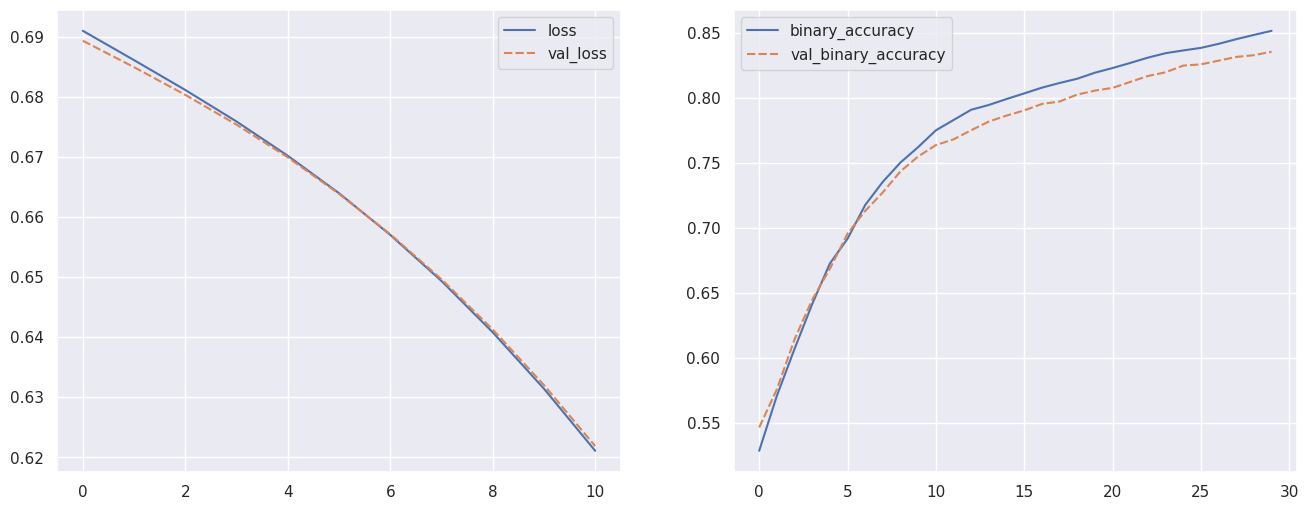

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history_f.loc[:10, ['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history_f.loc[:30, ['binary_accuracy', 'val_binary_accuracy']]);

### Avaliando o modelo treinado

Podemos re-utilizar as ferramentas do scikit-learn que aprendemos até agora para avaliar o modelo:

In [ ]:
model.load_weights('networks-2-best-weights.h5')

from sklearn import metrics

probabilities = model.predict(x_test)
predictions = (probabilities > .5).astype(float)

print(metrics.classification_report(y_test.ravel(), predictions.ravel()))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     12500
         1.0       0.83      0.83      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



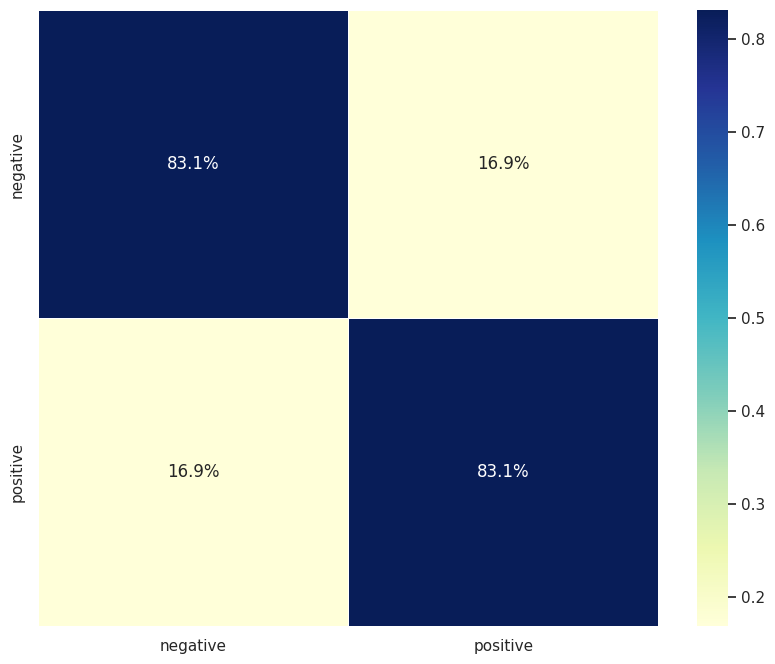

In [ ]:
c = metrics.confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1).reshape(-1, 1)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%', xticklabels=labels, yticklabels=labels);